In [1]:
pip install shap

In [2]:
pip install openpyxl


In [3]:
import shap
from google.colab import files
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [4]:
# Upload your CSV from local
uploaded = files.upload()

Saving combined_private.xlsx to combined_private.xlsx
Saving combined_questions_private.xlsx to combined_questions_private.xlsx


In [5]:
# Load it into a DataFrame
df = pd.read_excel("combined_private.xlsx")  # replace with actual filename

In [6]:
# Load it into a DataFrame
df_pitanja = pd.read_excel("combined_questions_private.xlsx")  # replace with actual filename

In [7]:
df = df.drop(columns=[
    'source_file'
])


In [8]:
ordinal_vars = []

for qid, qtype, options in zip(df_pitanja["QuestionID"], df_pitanja["Type"], df_pitanja["Options"]):
    if qtype == "Scale" and pd.notnull(options):
        choices = [opt.strip() for opt in str(options).split(';') if '=' in opt]
        if len(choices) > 3:   # more than 3 options
            ordinal_vars.append(str(qid))

# same cleanup you used (remove .0)
ordinal_vars = [str(int(float(col))) if str(col).endswith('.0') else str(col) for col in ordinal_vars]

In [9]:
select_one = []
for qid, qtype in zip(df_pitanja["QuestionID"], df_pitanja["Type"]):
    if qtype == "SelectOne":
        select_one.append(qid)
select_one = [str(int(float(col))) if str(col).endswith('.0') else str(col) for col in select_one]

In [10]:
multi_nominal_cols = []
for qid, qtype in zip(df_pitanja["QuestionID"], df_pitanja["Type"]):
    if qtype == "SelectMultiple":
        multi_nominal_cols.append(qid)
multi_nominal_cols = [str(int(float(col))) if str(col).endswith('.0') else str(col) for col in multi_nominal_cols]

In [11]:
binary = []

for qid, qtype, options in zip(df_pitanja["QuestionID"], df_pitanja["Type"], df_pitanja["Options"]):
    if qtype == "Scale" and pd.notnull(options):
        choices = [opt.strip() for opt in str(options).split(';') if '=' in opt]
        if len(choices) <= 3:   # <= 3 options
            binary.append(str(qid))

binary = [str(int(float(col))) if str(col).endswith('.0') else str(col) for col in binary]

In [12]:
# See missing values per column
df_mising=df.isnull().sum().sort_values(ascending=False)

In [13]:
df_mising

,0
324.5,6332
1525,6064
411.10,5677
485,5582
2142,5476
...,...
was_asked__2573,0
was_asked__2575,0
was_asked__321.15,0
was_asked__2577,0


In [14]:
za_drop = []

for index, value in df_mising.items():
    if value > 5000:
        za_drop.append(index)

In [15]:
za_drop = [str(int(float(col))) if str(col).endswith('.0') else str(col) for col in za_drop]

In [16]:
za_drop2 = []

for qid, qtype in zip(df_pitanja["QuestionID"], df_pitanja["Type"]):
    if qtype == "Text":
        za_drop2.append(str(qid))  # convert to string here


In [17]:
za_drop2_cleaned = [str(int(float(col))) if str(col).endswith('.0') else str(col) for col in za_drop2]

In [18]:
# 🔹 Step 2: Drop rows where 379.1 is missing
df = df[df['381'].notna()]

In [19]:
df = df.drop(columns=za_drop)

In [20]:
df = df.drop(columns=za_drop2_cleaned, errors='ignore')


In [21]:
# Step 2: Filter out columns that don’t exist in the DataFrame
ordinal_vars = [col for col in ordinal_vars if col in df.columns]

# Step 3: Convert only valid ones
for col in ordinal_vars:
    df[col] = df[col].astype('Int64')


In [22]:
for col in multi_nominal_cols:
    if col in df.columns:
        # Step 1: Clean missing and convert to string
        df[col] = df[col].fillna('').astype(str)

        # Step 2: One-hot encode selections
        dummies = df[col].str.get_dummies(sep=';')
        dummies.columns = [f"{col}_{c.strip()}" for c in dummies.columns]

        # Step 3: Create missing-all flag BEFORE dropping or joining
        df[f'{col}_missing_all'] = dummies.sum(axis=1).eq(0).astype(int)

        # Step 4: Replace original with dummies
        df = df.drop(columns=[col])
        df = pd.concat([df, dummies], axis=1)


In [23]:
for col in select_one:
    if col in df.columns:
        # Step 1: Clean missing and convert to string
        df[col] = df[col].fillna('').astype(str)

        # Step 2: One-hot encode selections
        dummies = df[col].str.get_dummies(sep=',')
        dummies.columns = [f"{col}_{c.strip()}" for c in dummies.columns]

        # Step 3: Create missing-all flag BEFORE dropping or joining
        df[f'{col}_missing_all'] = dummies.sum(axis=1).eq(0).astype(int)

        # Step 4: Replace original with dummies
        df = df.drop(columns=[col])
        df = pd.concat([df, dummies], axis=1)


In [24]:
for col in binary:
    if col in df.columns:
        # Step 1: Clean missing and convert to string
        df[col] = df[col].fillna('').astype(str)

        # Step 2: One-hot encode selections
        dummies = df[col].str.get_dummies(sep=',')
        dummies.columns = [f"{col}_{c.strip()}" for c in dummies.columns]

        # Step 3: Create missing-all flag BEFORE dropping or joining
        df[f'{col}_missing_all'] = dummies.sum(axis=1).eq(0).astype(int)

        # Step 4: Replace original with dummies
        df = df.drop(columns=[col])
        df = pd.concat([df, dummies], axis=1)

In [25]:
import numpy as np

# Compute correlation matrix
corr = df.corr()

# Extract upper triangle (to avoid duplicates)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Unstack into long form
strong_corr = (
    upper.stack()
    .reset_index()
    .rename(columns={0: "Correlation", "level_0": "Var1", "level_1": "Var2"})
)

# Filter for absolute correlation above threshold
threshold = 0.8
strong_corr = strong_corr[strong_corr["Correlation"].abs() > threshold]

print(strong_corr)

                    Var1               Var2  Correlation
10413               2571               2572     0.810927
10844   was_asked__476.3   was_asked__474.2     1.000000
10845   was_asked__476.3   was_asked__475.1     1.000000
10846   was_asked__476.3   was_asked__230.6     1.000000
10847   was_asked__476.3    was_asked__1094     1.000000
...                  ...                ...          ...
28961  487.2_missing_all          487.2_2.0    -0.847387
28963  487.2_missing_all  490.3_missing_all     0.974339
28965  487.2_missing_all          490.3_2.0    -0.850950
28974          487.2_2.0  490.3_missing_all    -0.825885
28983  490.3_missing_all          490.3_2.0    -0.873737

[1350 rows x 3 columns]


In [26]:
def nps_reverse(score):
    if score in [1, 2]:
        return 1
    elif score in [3, 4]:
        return 1
    else:
        return 0

df["nps_category"] = df["381"].apply(nps_reverse)


In [27]:
cols_to_drop = ["381"]
df = df.drop(columns=cols_to_drop)

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# ─────────── STEP 1: Identify target and excluded columns ───────────
target_col = "nps_category"
excluded_columns = [target_col]  # add any other cols you don’t want to touch

# columns that are already in the "normal/positive" direction (DON'T flip these)
always_normal_direction = ["561"]  # put your known positive-direction columns here

# ─────────── STEP 2: Determine which columns to standardize ───────────
# (exclude target; only columns with >2 unique values; numeric-only for scaling)
columns_to_standardize = [
    c for c in df.columns
    if c not in excluded_columns and df[c].nunique(dropna=True) > 2
]

# ─────────── STEP 3: Flip scale direction if needed (skip binaries just in case) ───────────
df_proc = df.copy()
cols_to_flip = []

for c in columns_to_standardize:
    if c in always_normal_direction:
        continue
    if df[c].nunique(dropna=True) == 2:
        continue  # safety: skip binary columns
    try:
        df_proc[c] = pd.to_numeric(df_proc[c], errors="coerce")
        col_min, col_max = df_proc[c].min(), df_proc[c].max()
        df_proc[c] = col_max + col_min - df_proc[c]
        cols_to_flip.append(c)
    except Exception as e:
        print(f"⚠️ Skipping flip: {c} ({e})")

# ─────────── STEP 4: Ensure numeric columns ───────────
for c in columns_to_standardize:
    df_proc[c] = pd.to_numeric(df_proc[c], errors="coerce")

# ─────────── STEP 5: Prepare model inputs ───────────
X = df_proc.drop(columns=[target_col])
Y = df_proc[target_col]

# Split FIRST ✅ (so imputer/scaler learn only from training data)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=2
)

# Only standardize columns that exist in X_train (and are not the target)
columns_to_standardize = [c for c in columns_to_standardize if c in X_train.columns]

# ─────────── STEP 6: Impute missing values on TRAIN only, apply to TEST ───────────
imputer = SimpleImputer(strategy="median")
X_train[columns_to_standardize] = imputer.fit_transform(X_train[columns_to_standardize])
X_test[columns_to_standardize] = imputer.transform(X_test[columns_to_standardize])

# ─────────── STEP 7: Standardize TRAIN only, apply to TEST ───────────
scaler = StandardScaler()
X_train[columns_to_standardize] = scaler.fit_transform(X_train[columns_to_standardize])
X_test[columns_to_standardize] = scaler.transform(X_test[columns_to_standardize])

print("Columns flipped:", len(cols_to_flip))
print("Columns standardized:", len(columns_to_standardize))


Columns flipped: 59
Columns standardized: 59


In [29]:
Y_test.shape


(1492,)

In [30]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [31]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(estimator=lr, param_grid=parameters, cv=10)


# Step 4: Fit the GridSearchCV object to the training data
logreg_cv.fit(X_train, Y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [32]:
print("\n★ Logistic Regression")
print("    best params  :", logreg_cv.best_params_)
print(f"    CV accuracy  : {logreg_cv.best_score_:.3f}")
print(f"    TEST accuracy: {logreg_cv.score(X_test, Y_test):.3f}")

# Predict on test set
Y_pred = logreg_cv.predict(X_test)



★ Logistic Regression
    best params  : {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
    CV accuracy  : 0.865
    TEST accuracy: 0.847


,β
166.4,0.658698
222,0.342210
"2563_Tipps, wie ich bei den Ausgaben sparen kann",0.329007
490.3_3.0,0.326346
520.1,0.322237
...,...
2572,-0.001308
was_asked__388,-0.000819
was_asked__473.2,-0.000819
was_asked__239.1,-0.000819


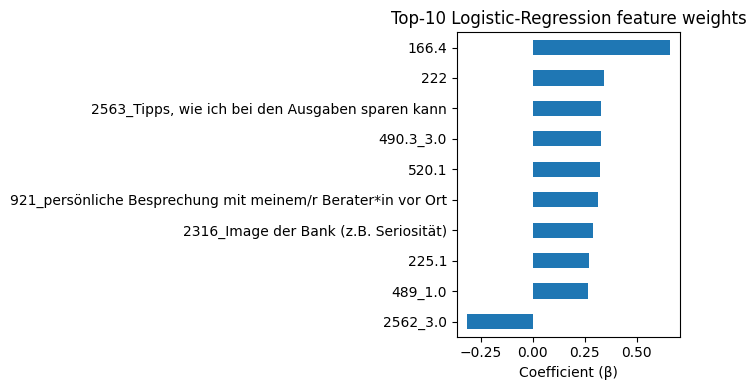

In [33]:
best_lr = logreg_cv.best_estimator_
coef = pd.Series(best_lr.coef_[0], index=X.columns, name="β") \
          .sort_values(key=lambda s: s.abs(), ascending=False)

display(coef.to_frame())        # full table

(
    coef.head(10)
        .sort_values()          # order for tidy barh
        .plot(kind="barh", figsize=(7, 4))
)
plt.title("Top-10 Logistic-Regression feature weights")
plt.xlabel("Coefficient (β)")
plt.tight_layout()
plt.show()

,Average Impact
166.4,0.459331
222,0.268054
520.1,0.244331
225.1,0.194144
90.3,0.182245
391.12,0.174116
was_asked__253,0.171853
was_asked__324.2,0.158749
2560_missing_all,0.156747
128.6,0.150288


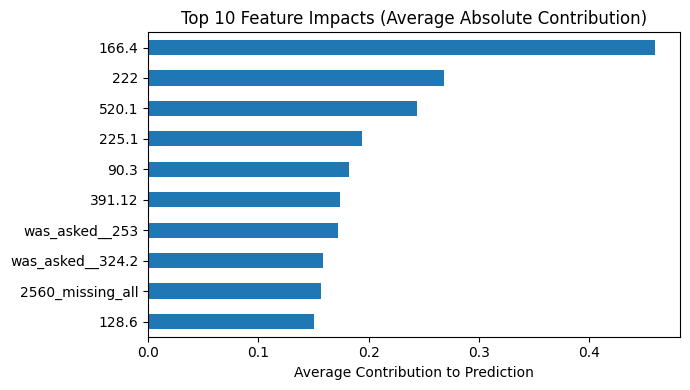

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

best_lr = logreg_cv.best_estimator_
coefs = best_lr.coef_.ravel()

# build a scaled full X in the SAME column order as training
X_scaled_full = pd.concat([X_train, X_test], axis=0).loc[:, X_train.columns]

contributions = X_scaled_full.to_numpy() * coefs
average_absolute_impact = np.abs(contributions).mean(axis=0)

impact_series = pd.Series(average_absolute_impact, index=X_train.columns).sort_values(ascending=False)

display(impact_series.head(10).to_frame(name="Average Impact"))

impact_series.head(10).sort_values().plot(kind="barh", figsize=(7, 4))
plt.title("Top 10 Feature Impacts (Average Absolute Contribution)")
plt.xlabel("Average Contribution to Prediction")
plt.tight_layout()
plt.show()



🔻 Average Negative Contribution of Each Feature (FULL):



,Average Negative Impact
166.4,0.230307
was_asked__253,0.171853
2560_missing_all,0.156747
222,0.134230
520.1,0.123067
486.4_missing_all,0.098586
225.1,0.097685
90.3,0.091419
391.12,0.087161
128.6,0.075720


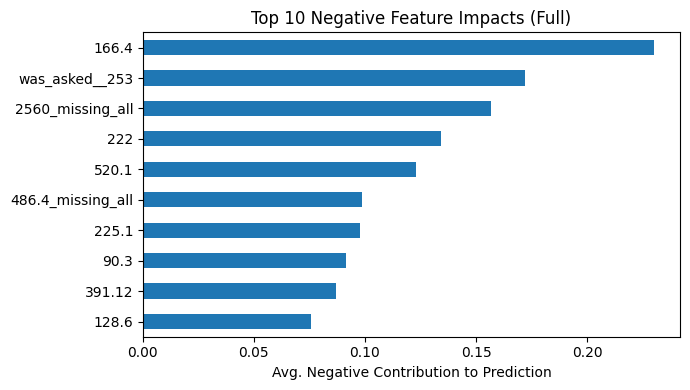

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

best_lr = logreg_cv.best_estimator_
coefs = best_lr.coef_.ravel()

X_scaled_full = pd.concat([X_train, X_test], axis=0).loc[:, X_train.columns]

contributions = X_scaled_full.to_numpy() * coefs
negative_contributions = np.where(contributions < 0, contributions, 0)
average_negative_impact = np.abs(negative_contributions).mean(axis=0)

impact_series = pd.Series(average_negative_impact, index=X_train.columns).sort_values(ascending=False)

print("\n🔻 Average Negative Contribution of Each Feature (FULL):\n")
display(impact_series.head(10).to_frame(name="Average Negative Impact"))

impact_series.head(10).sort_values().plot(kind="barh", figsize=(7, 4))
plt.title("Top 10 Negative Feature Impacts (Full)")
plt.xlabel("Avg. Negative Contribution to Prediction")
plt.tight_layout()
plt.show()


In [36]:
import numpy as np
import pandas as pd

best_lr = logreg_cv.best_estimator_

X_scaled_full = pd.concat([X_train, X_test], axis=0).loc[:, X_train.columns]

probs = best_lr.predict_proba(X_scaled_full)[:, 1]
p_term = (probs * (1 - probs))[:, np.newaxis]
marginal_effects = p_term * best_lr.coef_
average_marginal_effect = marginal_effects.mean(axis=0).ravel()

ame_series = pd.Series(average_marginal_effect, index=X_train.columns).abs().sort_values(ascending=False)

print("\n✅ Top 10 Features by Average Marginal Effect (AME) — FULL:\n")
display(ame_series.head(10).to_frame(name="Average Marginal Effect"))



✅ Top 10 Features by Average Marginal Effect (AME) — FULL:



,Average Marginal Effect
166.4,0.063781
222,0.033136
"2563_Tipps, wie ich bei den Ausgaben sparen kann",0.031857
490.3_3.0,0.031600
520.1,0.031202
2562_3.0,0.030596
921_persönliche Besprechung mit meinem/r Berater*in vor Ort,0.030302
2316_Image der Bank (z.B. Seriosität),0.028096
225.1,0.026206
489_1.0,0.025476
